In [1]:
import torch
print(f"현재 PyTorch: {torch.__version__}")
print(f"현재 CUDA: {torch.version.cuda}")

현재 PyTorch: 2.9.0+cu128
현재 CUDA: 12.8


In [2]:
!pip install diffusers transformers accelerate

In [3]:
from google.colab import userdata
import os

# Colab Secrets에서 토큰 불러오기
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

# Hugging Face 로그인
!huggingface-cli login --token $HF_TOKEN


/bin/bash: line 1: huggingface-cli: command not found


In [4]:
# 노션 페이지의 카테고리 → QuickDraw 실제 이름
category_mapping = {
    # Tier 1: 구체적 개념
    'water': 'cup',  # 물 → 컵
    'toilet': 'toilet',  # 화장실 ✓

    # Tier 2: 통증 표현
    'lightning': 'lightning',  # 번개 ✓
    'knife': 'knife',  # 칼 ✓

    # Tier 3: 감정 표현
    'face': 'face',  # 얼굴 ✓
    'cloud': 'cloud',  # 구름 ✓
    'heart': 'heart',  # 하트 ✓

    # 추가 (노션에서 언급된 것들)
    'storm': 'cloud',  # 폭풍 → 구름 사용
    'broken_heart': 'heart',  # 깨진 하트 → 하트 수정
}

print("✅ 카테고리 매칭 완료!")
for original, quickdraw in category_mapping.items():
    print(f"  {original:15s} → {quickdraw}")


✅ 카테고리 매칭 완료!
  water           → cup
  toilet          → toilet
  lightning       → lightning
  knife           → knife
  face            → face
  cloud           → cloud
  heart           → heart
  storm           → cloud
  broken_heart    → heart


In [5]:
import requests
import json
from PIL import Image, ImageDraw

def download_quickdraw(category_name, num_samples=10):
    """
    QuickDraw에서 실제 스케치 다운로드

    Args:
        category_name: QuickDraw 카테고리 이름 (위 리스트에서)
        num_samples: 다운로드할 샘플 수
    """
    # URL 생성 (공백은 %20으로)
    url_name = category_name.replace(' ', '%20')
    url = f"https://storage.googleapis.com/quickdraw_dataset/full/simplified/{url_name}.ndjson"

    print(f"📥 다운로드: {category_name}...", end=" ")

    try:
        # 스트리밍으로 다운로드 (메모리 절약)
        response = requests.get(url, stream=True, timeout=30)
        response.raise_for_status()

        sketches = []
        lines_read = 0

        # 줄 단위로 읽기
        for line in response.iter_lines():
            if lines_read >= num_samples:
                break

            if line:
                try:
                    sketch_data = json.loads(line.decode('utf-8'))
                    sketches.append(sketch_data)
                    lines_read += 1
                except:
                    continue

        print(f"✅ {len(sketches)}장")
        return sketches

    except Exception as e:
        print(f"❌ 실패: {e}")
        return []

# 테스트: cup 다운로드
test_sketches = download_quickdraw('cup', 3)

if test_sketches:
    print(f"\n샘플 데이터 구조:")
    print(f"  키: {test_sketches[0].keys()}")
    print(f"  단어: {test_sketches[0]['word']}")
    print(f"  스트로크 수: {len(test_sketches[0]['drawing'])}")


📥 다운로드: cup... ✅ 3장

샘플 데이터 구조:
  키: dict_keys(['word', 'countrycode', 'timestamp', 'recognized', 'key_id', 'drawing'])
  단어: cup
  스트로크 수: 3


In [6]:
# 실험에 필요한 카테고리 (QuickDraw 이름으로)
quickdraw_categories = {
    'tier1_concrete': ['cup', 'toilet'],
    'tier2_pain': ['lightning', 'knife'],
    'tier3_emotion': ['face', 'cloud', 'heart']
}

# 모든 카테고리 다운로드
all_sketches = {}

print("🚀 QuickDraw 다운로드 시작\n")
print("="*60)

for tier, categories in quickdraw_categories.items():
    print(f"\n📁 {tier}")
    for cat in categories:
        sketches = download_quickdraw(cat, num_samples=10)
        if sketches:
            all_sketches[cat] = sketches

print("\n" + "="*60)
print(f"✅ 다운로드 완료!")
print(f"   총 {len(all_sketches)}개 카테고리")
print(f"   총 {sum(len(s) for s in all_sketches.values())}장")
print("="*60)

# 카테고리 확인
for cat, data in all_sketches.items():
    print(f"  ✓ {cat:15s}: {len(data)}장")


🚀 QuickDraw 다운로드 시작


📁 tier1_concrete
📥 다운로드: cup... ✅ 10장
📥 다운로드: toilet... ✅ 10장

📁 tier2_pain
📥 다운로드: lightning... ✅ 10장
📥 다운로드: knife... ✅ 10장

📁 tier3_emotion
📥 다운로드: face... ✅ 10장
📥 다운로드: cloud... ✅ 10장
📥 다운로드: heart... ❌ 실패: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/simplified/heart.ndjson

✅ 다운로드 완료!
   총 6개 카테고리
   총 60장
  ✓ cup            : 10장
  ✓ toilet         : 10장
  ✓ lightning      : 10장
  ✓ knife          : 10장
  ✓ face           : 10장
  ✓ cloud          : 10장


In [7]:
def render_quickdraw_sketch(sketch_data, size=512):
    """
    QuickDraw JSON을 이미지로 변환

    Args:
        sketch_data: dict (QuickDraw의 JSON 데이터)
        size: int (출력 이미지 크기)
    """
    img = Image.new('RGB', (size, size), 'white')
    draw = ImageDraw.Draw(img)

    drawing = sketch_data['drawing']

    # 모든 좌표의 범위 계산
    all_x = [x for stroke in drawing for x in stroke[0]]
    all_y = [y for stroke in drawing for y in stroke[1]]

    if not all_x or not all_y:
        return img

    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    # 정규화 함수 (패딩 포함)
    def normalize(val, min_val, max_val, target_size):
        if max_val == min_val:
            return target_size // 2
        padding = 30
        normalized = (val - min_val) / (max_val - min_val)
        return int(padding + normalized * (target_size - 2*padding))

    # 각 스트로크 그리기
    for stroke in drawing:
        x_coords = stroke[0]
        y_coords = stroke[1]

        for i in range(len(x_coords) - 1):
            x1 = normalize(x_coords[i], min_x, max_x, size)
            y1 = normalize(y_coords[i], min_y, max_y, size)
            x2 = normalize(x_coords[i+1], min_x, max_x, size)
            y2 = normalize(y_coords[i+1], min_y, max_y, size)

            draw.line([(x1, y1), (x2, y2)], fill='black', width=3)

    return img

# 테스트: 첫 번째 컵 스케치 렌더링
if 'cup' in all_sketches:
    test_img = render_quickdraw_sketch(all_sketches['cup'][0])
    test_img  # Colab에서 자동 표시


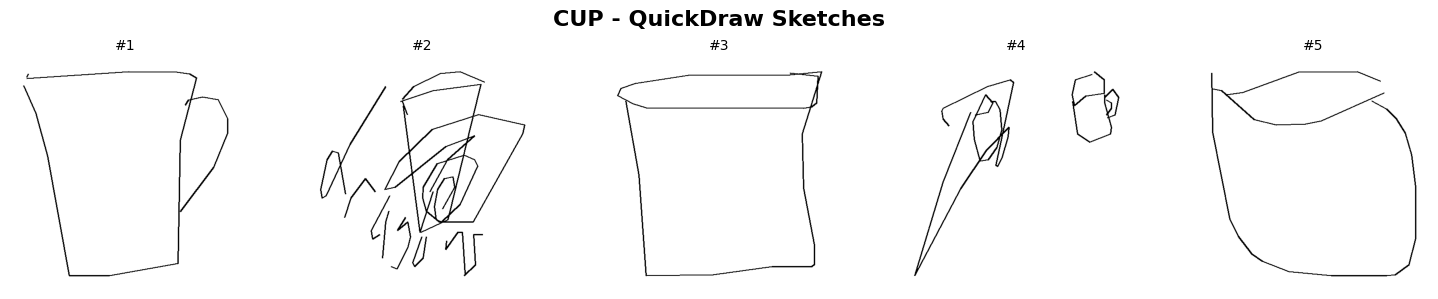

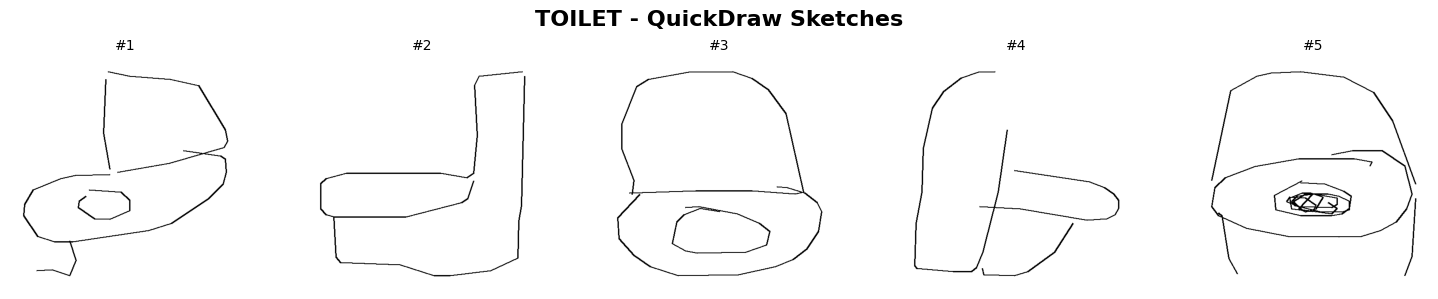

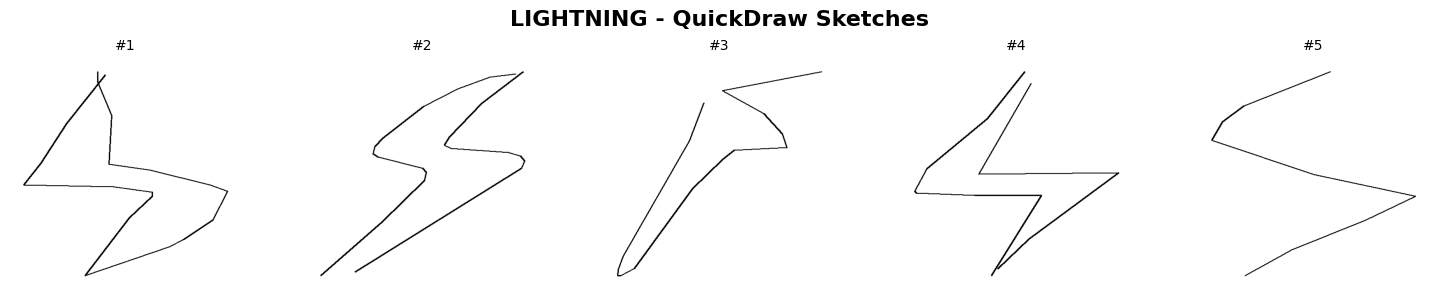

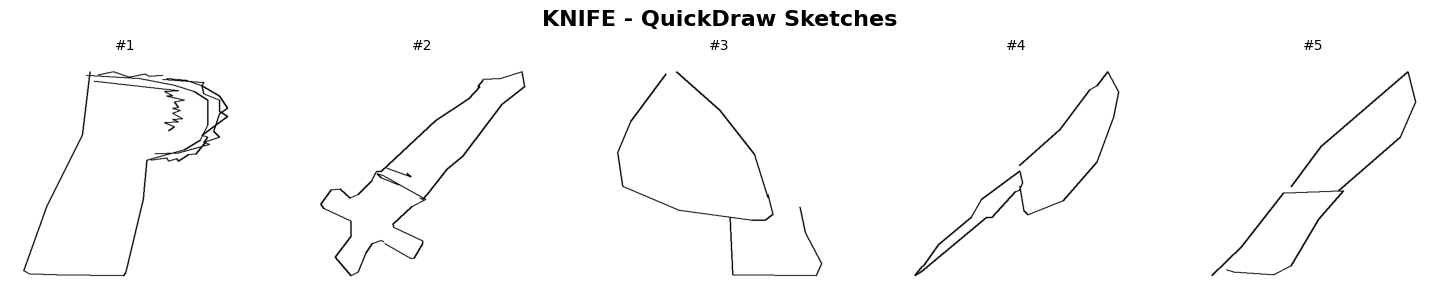

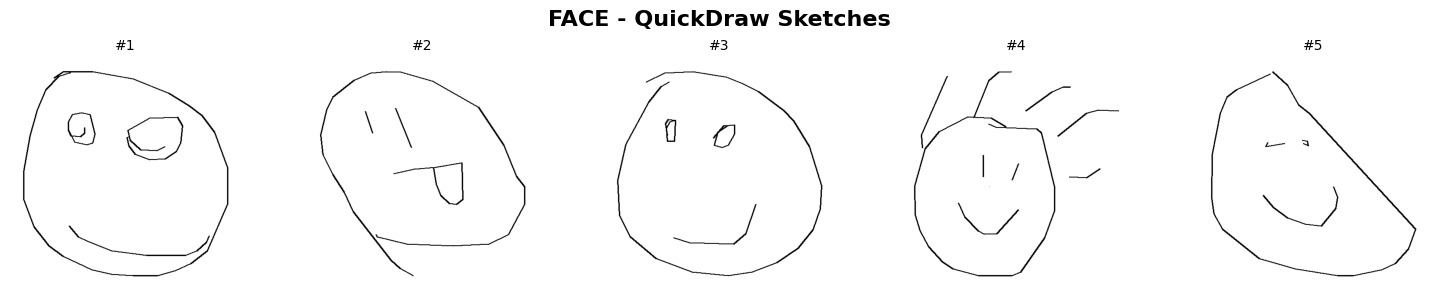

In [8]:
# 시각화: 다운로드한 스케치 확인
import matplotlib.pyplot as plt

def visualize_category(category, num_show=5):
    """카테고리별 스케치 시각화"""
    if category not in all_sketches:
        print(f"❌ {category}가 없습니다.")
        return

    sketches = all_sketches[category]
    num_show = min(num_show, len(sketches))

    fig, axes = plt.subplots(1, num_show, figsize=(15, 3))
    if num_show == 1:
        axes = [axes]

    fig.suptitle(f'{category.upper()} - QuickDraw Sketches',
                 fontsize=16, fontweight='bold')

    for i in range(num_show):
        img = render_quickdraw_sketch(sketches[i])
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'#{i+1}', fontsize=10)

    plt.tight_layout()
    plt.show()

# 각 카테고리 확인
for cat in ['cup', 'toilet', 'lightning', 'knife', 'face']:
    if cat in all_sketches:
        visualize_category(cat, 5)


In [9]:
## 1단계 - 커스텀 스케치
import numpy as np
from PIL import Image, ImageDraw
import random

# 1. Zigzag (욱신거리는 통증)
def generate_zigzag(num_waves=3, size=512):
    img = Image.new('RGB', (size, size), 'white')
    draw = ImageDraw.Draw(img)

    points = []
    for i in range(150):
        x = 50 + i * 3
        y = size // 2 + 80 * np.sin(i * num_waves * 0.08)
        points.append((x, y))

    draw.line(points, fill='black', width=4)
    return img

# 2. Prison Bars (답답함/갑갑함)
def generate_prison_bars(num_bars=6, size=512):
    img = Image.new('RGB', (size, size), 'white')
    draw = ImageDraw.Draw(img)

    # 수직 창살
    start_x = 100
    spacing = 250 // num_bars
    for i in range(num_bars):
        x = start_x + i * spacing
        draw.line([(x, 100), (x, 400)], fill='black', width=5)

    # 수평 연결 바
    draw.line([(start_x-20, 150), (start_x + (num_bars-1)*spacing + 20, 150)],
              fill='black', width=5)
    draw.line([(start_x-20, 350), (start_x + (num_bars-1)*spacing + 20, 350)],
              fill='black', width=5)

    return img

# 3. Broken Heart (슬픔)
def generate_broken_heart(size=512):
    img = Image.new('RGB', (size, size), 'white')
    draw = ImageDraw.Draw(img)

    center = size // 2

    # 왼쪽 하트 반쪽
    draw.arc([center-120, 150, center-20, 280], 0, 180, fill='black', width=4)
    draw.line([(center-120, 215), (center-30, 380)], fill='black', width=4)

    # 오른쪽 하트 반쪽
    draw.arc([center+20, 150, center+120, 280], 0, 180, fill='black', width=4)
    draw.line([(center+120, 215), (center+30, 380)], fill='black', width=4)

    # 가운데 금 (지그재그)
    crack_points = [
        (center-30, 200), (center-10, 240), (center+10, 280),
        (center-5, 320), (center+15, 360), (center, 380)
    ]
    draw.line(crack_points, fill='black', width=4)

    return img

# 각 카테고리 10장씩 생성
print("🎨 커스텀 스케치 생성 중...\n")

# Zigzag 10장
zigzag_sketches = []
for i in range(10):
    num_waves = random.randint(2, 5)
    img = generate_zigzag(num_waves)
    zigzag_sketches.append(img)
print(f"✅ zigzag: 10장")

# Prison Bars 10장
prison_sketches = []
for i in range(10):
    num_bars = random.randint(5, 8)
    img = generate_prison_bars(num_bars)
    prison_sketches.append(img)
print(f"✅ prison_bars: 10장")

# Broken Heart 10장
heart_sketches = []
for i in range(10):
    img = generate_broken_heart()
    heart_sketches.append(img)
print(f"✅ broken_heart: 10장")

# all_sketches에 추가
all_sketches['zigzag'] = zigzag_sketches
all_sketches['prison_bars'] = prison_sketches
all_sketches['broken_heart'] = heart_sketches

print(f"\n{'='*60}")
print(f"✅ 전체 데이터 준비 완료!")
print(f"   총 {len(all_sketches)}개 카테고리")
print(f"   총 {60 + 30}장 (QuickDraw 60 + 커스텀 30)")
print(f"{'='*60}")


🎨 커스텀 스케치 생성 중...

✅ zigzag: 10장
✅ prison_bars: 10장
✅ broken_heart: 10장

✅ 전체 데이터 준비 완료!
   총 9개 카테고리
   총 90장 (QuickDraw 60 + 커스텀 30)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



🧪 실험 2: AAC 복합 의사소통 - 점진적 요소 추가 시 구조 보존
목표: 환자가 요소를 추가할 때 이전 요소가 깨지지 않고 유지되는지 검증
시나리오: 환자가 '물 마시고 싶다' → '침대에서' → '도와주세요'로 확장

🎨 점진적 스케치 생성 중...

✅ 1단계: 물컵만 (기본 요청)
✅ 2단계: 물컵 + 사람 (누가 마실지 명확화)
✅ 3단계: 물컵 + 사람 + 침대 (어디서 필요한지 명확화)

🔍 ControlNet 입력 형식으로 변환 중...

✅ ControlNet 입력 준비 완료!

📋 실험 설정:
   - ControlNet: lllyasviel/control_v11p_sd15_scribble
   - 1단계: 물컵만
   - 2단계: 물컵(위치 고정) + 사람 추가
   - 3단계: 물컵(위치 고정) + 사람(위치 고정) + 침대 추가
   - CFG Scale: 7.0
   - ControlNet Scale: 1.0
   - Seed: 42

🎨 ControlNet 이미지 생성 시작...

[1/3] 1단계: 물컵만
   프롬프트: "a glass of water on a table"
   생성 중... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅

[2/3] 2단계: 물컵 + 사람
   프롬프트: "a glass of water with a person reaching for it"
   생성 중... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅

[3/3] 3단계: 물컵 + 사람 + 침대
   프롬프트: "a glass of water, a person, and a hospital bed"
   생성 중... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅

✅ 실험 2 생성 완료!

📊 결과 시각화 중...



/tmp/ipython-input-3445324154.py:216: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3445324154.py:216: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3445324154.py:216: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3445324154.py:216: UserWarning: Glyph 52981 (\N{HANGUL SYLLABLE KEOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3445324154.py:216: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3445324154.py:216: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3445324154.py:216: UserWarning: Glyph 46988 (\N{HANGUL SYLLABLE RAM}) missing from font(s) DejaVu Sans.
  plt.tight_l

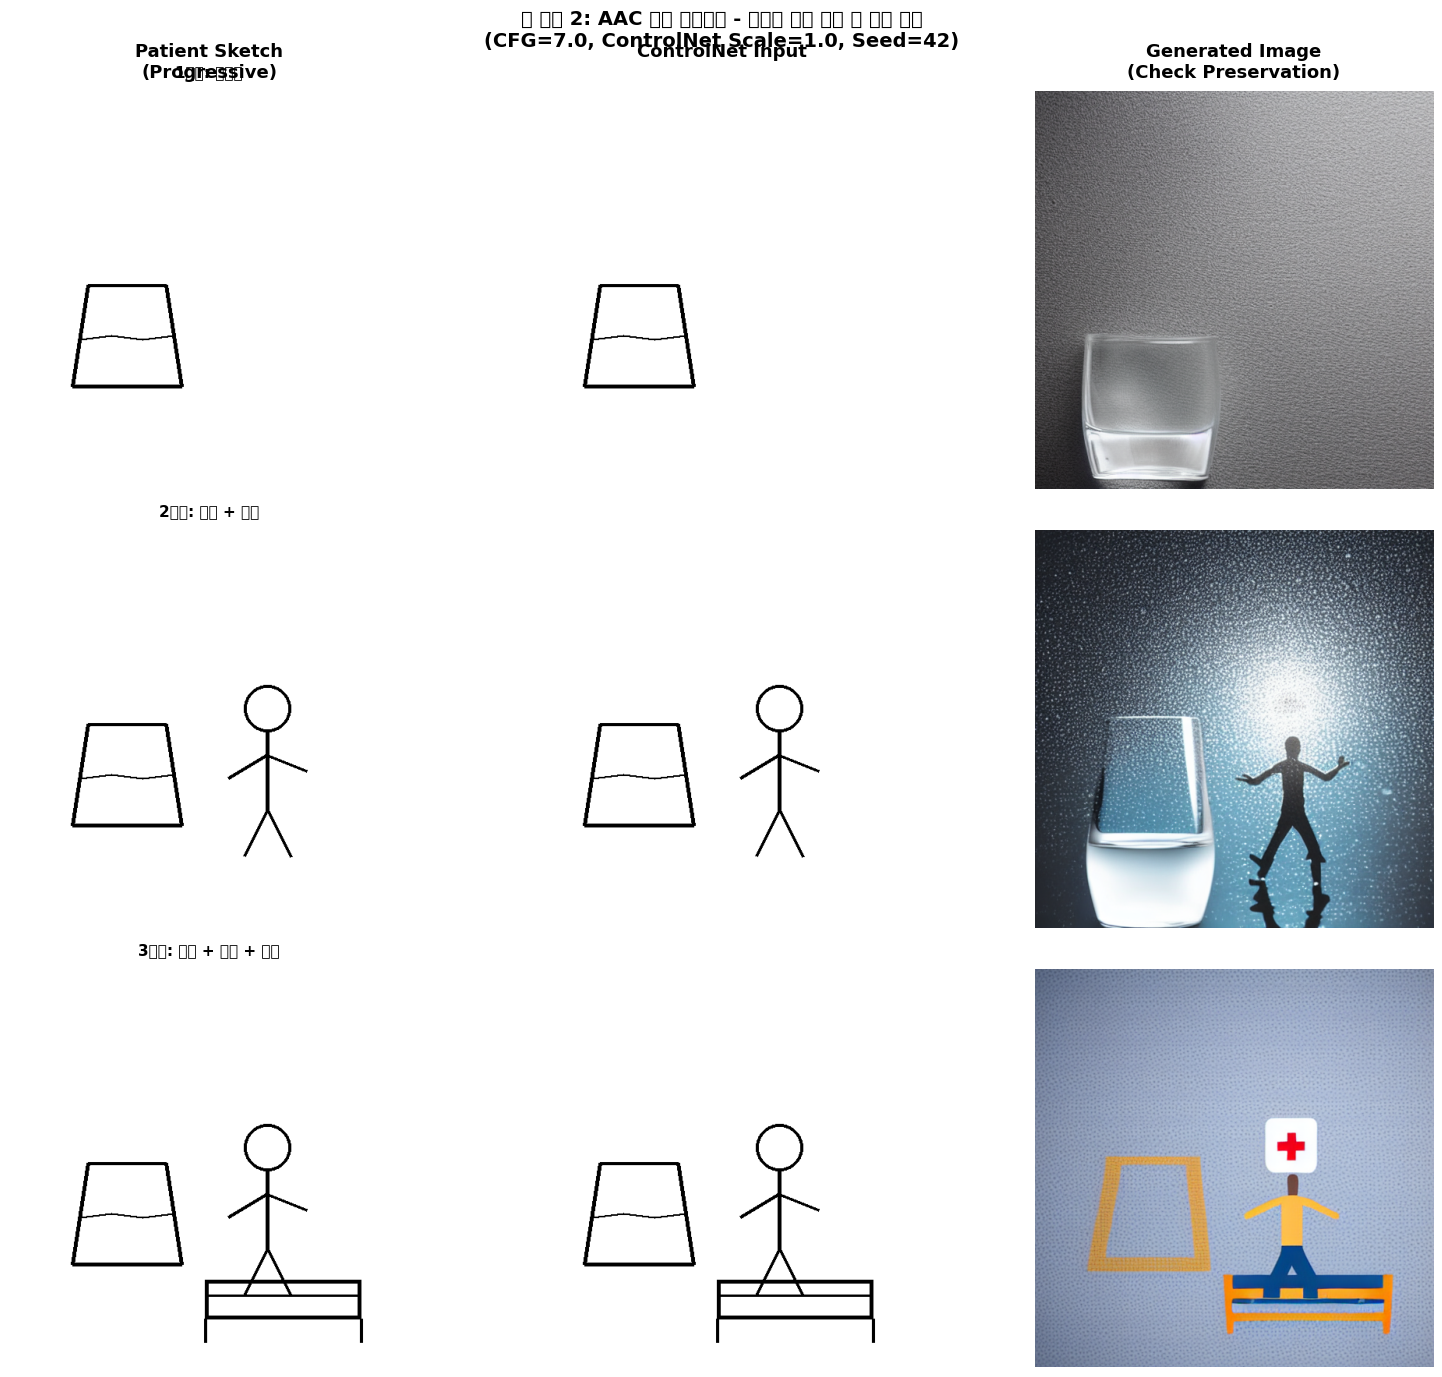

✅ 시각화 완료!

📋 ControlNet 구조 보존 평가 (핵심!)
1️⃣ 물컵 위치 보존:
   → 1단계에서 그린 물컵이 2단계, 3단계에서도 같은 위치에 있나요?
   → 사람이나 침대가 추가되어도 물컵이 사라지거나 이동하지 않나요?

2️⃣ 사람 위치 보존:
   → 2단계에서 추가된 사람이 3단계에서도 같은 위치/자세인가요?
   → 침대가 추가되어도 사람의 형태가 유지되나요?

3️⃣ 점진적 정보 추가:
   → 각 단계가 '추가'처럼 보이나요, 아니면 '완전히 다른 이미지'인가요?
   → 1단계 → 2단계 → 3단계로 '진화'하는 느낌이 있나요?

4️⃣ ControlNet의 역할:
   ✓ Without ControlNet:
      → 프롬프트만으로 생성 → 매번 랜덤한 위치/구도
      → 환자가 '추가'를 의도해도 시스템은 '새 이미지' 생성
   ✓ With ControlNet:
      → 스케치 구조를 강제로 따라감
      → 이전 요소(컵)의 위치를 유지한 채 새 요소(사람, 침대) 추가
      → 환자의 '점진적 의사소통' 의도가 정확히 전달됨!

5️⃣ AAC 실용성:
   → 환자: '물' 그림 → 잠깐, '누가 마실지' 추가 → '어디서' 추가
   → 시스템: 각 단계마다 이전 정보를 유지하며 업데이트
   → 의료진: 환자의 의도를 점진적으로 정확히 파악 가능

💾 개별 이미지 저장 중...
   ✓ 단계 1: /content/exp2_stage1_generated.png
   ✓ 단계 2: /content/exp2_stage2_generated.png
   ✓ 단계 3: /content/exp2_stage3_generated.png

💾 저장 위치:
   - 전체 비교: /content/experiment2_progressive_communication.png

🎉 실험 2 완료!

💡 실험 핵심 질문:
   Q1. 2단계 이미지에서 1단계의 '물컵'이 보존되었나요?
   Q2. 3단계 이미지에서 1단계

In [12]:
###############################################################################
# 🧪 실험 2: AAC 복합 의사소통 - 점진적 요소 추가 시 구조 보존
###############################################################################

from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

# 필요한 라이브러리 임포트 및 파이프라인 초기화
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

# ControlNet 모델 로드
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_scribble", torch_dtype=torch.float16)

# Stable Diffusion ControlNet 파이프라인 로드
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

# 스케줄러 설정 (더 빠른 생성을 위함)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# GPU로 파이프라인 이동
pipe.to("cuda")

print("\n" + "="*70)
print("🧪 실험 2: AAC 복합 의사소통 - 점진적 요소 추가 시 구조 보존")
print("="*70)
print("목표: 환자가 요소를 추가할 때 이전 요소가 깨지지 않고 유지되는지 검증")
print("시나리오: 환자가 '물 마시고 싶다' → '침대에서' → '도와주세요'로 확장")
print("="*70 + "\n")

# 1. 점진적 스케치 생성 (요소 추가)
print("🎨 점진적 스케치 생성 중...\n")

def create_stage1_cup(size=512):
    """1단계: 물컵만"""
    img = Image.new('L', (size, size), 255)
    draw = ImageDraw.Draw(img)

    # 컵 (왼쪽에 배치)
    draw.line([(100, 250), (80, 380)], fill=0, width=5)   # 왼쪽
    draw.line([(200, 250), (220, 380)], fill=0, width=5)  # 오른쪽
    draw.line([(80, 380), (220, 380)], fill=0, width=5)   # 바닥
    draw.line([(100, 250), (200, 250)], fill=0, width=4)  # 윗부분

    # 물 표시
    draw.line([(90, 320), (130, 315), (170, 320), (210, 315)], fill=0, width=3)

    return img

def create_stage2_cup_person(size=512):
    """2단계: 물컵 + 사람 (물을 마시려는)"""
    img = Image.new('L', (size, size), 255)
    draw = ImageDraw.Draw(img)

    # 1단계와 동일한 컵 (위치 고정!)
    draw.line([(100, 250), (80, 380)], fill=0, width=5)
    draw.line([(200, 250), (220, 380)], fill=0, width=5)
    draw.line([(80, 380), (220, 380)], fill=0, width=5)
    draw.line([(100, 250), (200, 250)], fill=0, width=4)
    draw.line([(90, 320), (130, 315), (170, 320), (210, 315)], fill=0, width=3)

    # 사람 추가 (오른쪽)
    draw.ellipse([300, 200, 360, 260], outline=0, width=4)  # 머리
    draw.line([(330, 260), (330, 360)], fill=0, width=5)    # 몸통
    draw.line([(330, 290), (280, 320)], fill=0, width=4)    # 왼팔 (컵 쪽으로)
    draw.line([(330, 290), (380, 310)], fill=0, width=4)    # 오른팔
    draw.line([(330, 360), (300, 420)], fill=0, width=4)    # 왼쪽 다리
    draw.line([(330, 360), (360, 420)], fill=0, width=4)    # 오른쪽 다리

    return img

def create_stage3_cup_person_bed(size=512):
    """3단계: 물컵 + 사람 + 침대 (침대에 누워서 물 필요)"""
    img = Image.new('L', (size, size), 255)
    draw = ImageDraw.Draw(img)

    # 1단계와 동일한 컵 (위치 고정!)
    draw.line([(100, 250), (80, 380)], fill=0, width=5)
    draw.line([(200, 250), (220, 380)], fill=0, width=5)
    draw.line([(80, 380), (220, 380)], fill=0, width=5)
    draw.line([(100, 250), (200, 250)], fill=0, width=4)
    draw.line([(90, 320), (130, 315), (170, 320), (210, 315)], fill=0, width=3)

    # 2단계와 동일한 사람 (위치 고정!)
    draw.ellipse([300, 200, 360, 260], outline=0, width=4)
    draw.line([(330, 260), (330, 360)], fill=0, width=5)
    draw.line([(330, 290), (280, 320)], fill=0, width=4)
    draw.line([(330, 290), (380, 310)], fill=0, width=4)
    draw.line([(330, 360), (300, 420)], fill=0, width=4)
    draw.line([(330, 360), (360, 420)], fill=0, width=4)

    # 침대 추가 (하단)
    draw.rectangle([250, 400, 450, 450], outline=0, width=5)  # 침대 프레임
    draw.line([(250, 420), (450, 420)], fill=0, width=3)      # 매트리스 선
    draw.line([(250, 450), (250, 480)], fill=0, width=4)      # 왼쪽 다리
    draw.line([(450, 450), (450, 480)], fill=0, width=4)      # 오른쪽 다리

    return img

# 스케치 생성
stage1 = create_stage1_cup()
stage2 = create_stage2_cup_person()
stage3 = create_stage3_cup_person_bed()

print("✅ 1단계: 물컵만 (기본 요청)")
print("✅ 2단계: 물컵 + 사람 (누가 마실지 명확화)")
print("✅ 3단계: 물컵 + 사람 + 침대 (어디서 필요한지 명확화)\n")

# 2. ControlNet 입력 준비
print("🔍 ControlNet 입력 형식으로 변환 중...\n")

def prepare_control_image(sketch):
    """흑백 스케치 → RGB 변환"""
    sketch_array = np.array(sketch)
    control_image = np.stack([sketch_array] * 3, axis=-1)
    return Image.fromarray(control_image)

control1 = prepare_control_image(stage1)
control2 = prepare_control_image(stage2)
control3 = prepare_control_image(stage3)

print("✅ ControlNet 입력 준비 완료!\n")

# 3. 프롬프트 설정 (스케치 내용 설명)
prompts = [
    "a glass of water on a table",  # 1단계
    "a glass of water with a person reaching for it",  # 2단계
    "a glass of water, a person, and a hospital bed"  # 3단계
]

# 실험 파라미터
cfg_scale = 7.0
controlnet_scale = 1.0
seed = 42
num_steps = 20

print("📋 실험 설정:")
print(f"   - ControlNet: lllyasviel/control_v11p_sd15_scribble")
print(f"   - 1단계: 물컵만")
print(f"   - 2단계: 물컵(위치 고정) + 사람 추가")
print(f"   - 3단계: 물컵(위치 고정) + 사람(위치 고정) + 침대 추가")
print(f"   - CFG Scale: {cfg_scale}")
print(f"   - ControlNet Scale: {controlnet_scale}")
print(f"   - Seed: {seed}\n")

# 4. ControlNet으로 이미지 생성
print("🎨 ControlNet 이미지 생성 시작...\n")

stages = [
    {'name': '1단계: 물컵만', 'sketch': stage1, 'control': control1, 'prompt': prompts[0]},
    {'name': '2단계: 물컵 + 사람', 'sketch': stage2, 'control': control2, 'prompt': prompts[1]},
    {'name': '3단계: 물컵 + 사람 + 침대', 'sketch': stage3, 'control': control3, 'prompt': prompts[2]}
]

experiment2_results = []

for i, stage in enumerate(stages, 1):
    print(f"[{i}/3] {stage['name']}")
    print(f"   프롬프트: \"{stage['prompt']}\"")
    print("   생성 중...", end=" ")

    generator = torch.manual_seed(seed)

    image = pipe(
        prompt=stage['prompt'],
        image=stage['control'],
        controlnet_conditioning_scale=controlnet_scale,
        guidance_scale=cfg_scale,
        num_inference_steps=num_steps,
        generator=generator
    ).images[0]

    stage['generated'] = image
    experiment2_results.append(stage)

    print("✅\n")

print("="*70)
print("✅ 실험 2 생성 완료!")
print("="*70 + "\n")

# 5. 결과 시각화
print("📊 결과 시각화 중...\n")

fig, axes = plt.subplots(3, 3, figsize=(16, 14))

# 헤더
headers = ['Patient Sketch\n(Progressive)', 'ControlNet Input', 'Generated Image\n(Check Preservation)']
for col, header in enumerate(headers):
    axes[0, col].text(0.5, 1.12, header,
                      transform=axes[0, col].transAxes,
                      ha='center', va='top',
                      fontsize=13, fontweight='bold')

# 각 단계별 행
for row, result in enumerate(experiment2_results):
    # 스케치
    axes[row, 0].imshow(result['sketch'], cmap='gray')
    axes[row, 0].set_title(result['name'], fontsize=11, pad=10, fontweight='bold')
    axes[row, 0].axis('off')

    # ControlNet 입력
    axes[row, 1].imshow(result['control'])
    axes[row, 1].axis('off')

    # 생성 결과
    axes[row, 2].imshow(result['generated'])
    axes[row, 2].axis('off')

plt.suptitle('🧪 실험 2: AAC 복합 의사소통 - 점진적 요소 추가 시 구조 보존\n' +
             f'(CFG={cfg_scale}, ControlNet Scale={controlnet_scale}, Seed={seed})',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('/content/experiment2_progressive_communication.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 시각화 완료!")

# 6. 평가 안내
print("\n" + "="*70)
print("📋 ControlNet 구조 보존 평가 (핵심!)")
print("="*70)
print("1️⃣ 물컵 위치 보존:")
print("   → 1단계에서 그린 물컵이 2단계, 3단계에서도 같은 위치에 있나요?")
print("   → 사람이나 침대가 추가되어도 물컵이 사라지거나 이동하지 않나요?")
print()
print("2️⃣ 사람 위치 보존:")
print("   → 2단계에서 추가된 사람이 3단계에서도 같은 위치/자세인가요?")
print("   → 침대가 추가되어도 사람의 형태가 유지되나요?")
print()
print("3️⃣ 점진적 정보 추가:")
print("   → 각 단계가 '추가'처럼 보이나요, 아니면 '완전히 다른 이미지'인가요?")
print("   → 1단계 → 2단계 → 3단계로 '진화'하는 느낌이 있나요?")
print()
print("4️⃣ ControlNet의 역할:")
print("   ✓ Without ControlNet:")
print("      → 프롬프트만으로 생성 → 매번 랜덤한 위치/구도")
print("      → 환자가 '추가'를 의도해도 시스템은 '새 이미지' 생성")
print("   ✓ With ControlNet:")
print("      → 스케치 구조를 강제로 따라감")
print("      → 이전 요소(컵)의 위치를 유지한 채 새 요소(사람, 침대) 추가")
print("      → 환자의 '점진적 의사소통' 의도가 정확히 전달됨!")
print()
print("5️⃣ AAC 실용성:")
print("   → 환자: '물' 그림 → 잠깐, '누가 마실지' 추가 → '어디서' 추가")
print("   → 시스템: 각 단계마다 이전 정보를 유지하며 업데이트")
print("   → 의료진: 환자의 의도를 점진적으로 정확히 파악 가능")
print("="*70)

# 7. 개별 이미지 저장
print("\n💾 개별 이미지 저장 중...")
for i, result in enumerate(experiment2_results, 1):
    filename = f"/content/exp2_stage{i}_generated.png"
    result['generated'].save(filename)
    print(f"   ✓ 단계 {i}: {filename}")

print("\n💾 저장 위치:")
print("   - 전체 비교: /content/experiment2_progressive_communication.png")

print("\n🎉 실험 2 완료!")
print("\n" + "="*70)
print("💡 실험 핵심 질문:")
print("   Q1. 2단계 이미지에서 1단계의 '물컵'이 보존되었나요?")
print("   Q2. 3단계 이미지에서 1단계의 '물컵' + 2단계의 '사람'이 보존되었나요?")
print("   Q3. ControlNet이 '점진적 의사소통'을 가능하게 했나요?")
print("\n   → 만약 보존되었다면: AAC에서 ControlNet 사용 가치 입증! ✅")
print("   → 만약 깨졌다면: ControlNet Scale 조정 또는 다른 전략 필요")
print("="*70)
